In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2

from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.datasets import Planetoid
from torch_geometric_temporal.dataset import METRLADatasetLoader
import pandas as pd
from torch_scatter import gather_csr, scatter, segment_csr

from sklearn.metrics import ConfusionMatrixDisplay
import sys
from utils_analysis import *

# auto refresh
%load_ext autoreload
%autoreload 2
# GPU support
DEVICE = torch.device('cuda:0') # cuda
shuffle=True
batch_size = 32

device = torch.device(
    "cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import os.path as osp
path = osp.join(osp.dirname('/mnt/d1/siji/projects/timeseries/'),
                    '..', 'data', 'Planetoid')
DATA_SET='Cora'
# DATA_SET='PubMed'
# DATA_SET='CiteSeer'
SPLIT='public'
dataset = Planetoid(path, name=DATA_SET, split=SPLIT)
# dataset = Planetoid(path, name='Cora', split=SPLIT)
data = dataset[0]

In [4]:
# number edges 
edges = data.edge_index.t().tolist()
print('edges', len(edges))
# print node
print('nodes', len(data.x))
# features per node
print('features per node', len(data.x[0]))
# how many train nodes?
print('train nodes', sum(data.train_mask))
# how many labels?
print('labels', len(data.y.unique()))


edges 10556
nodes 2708
features per node 1433
train nodes tensor(140)
labels 7


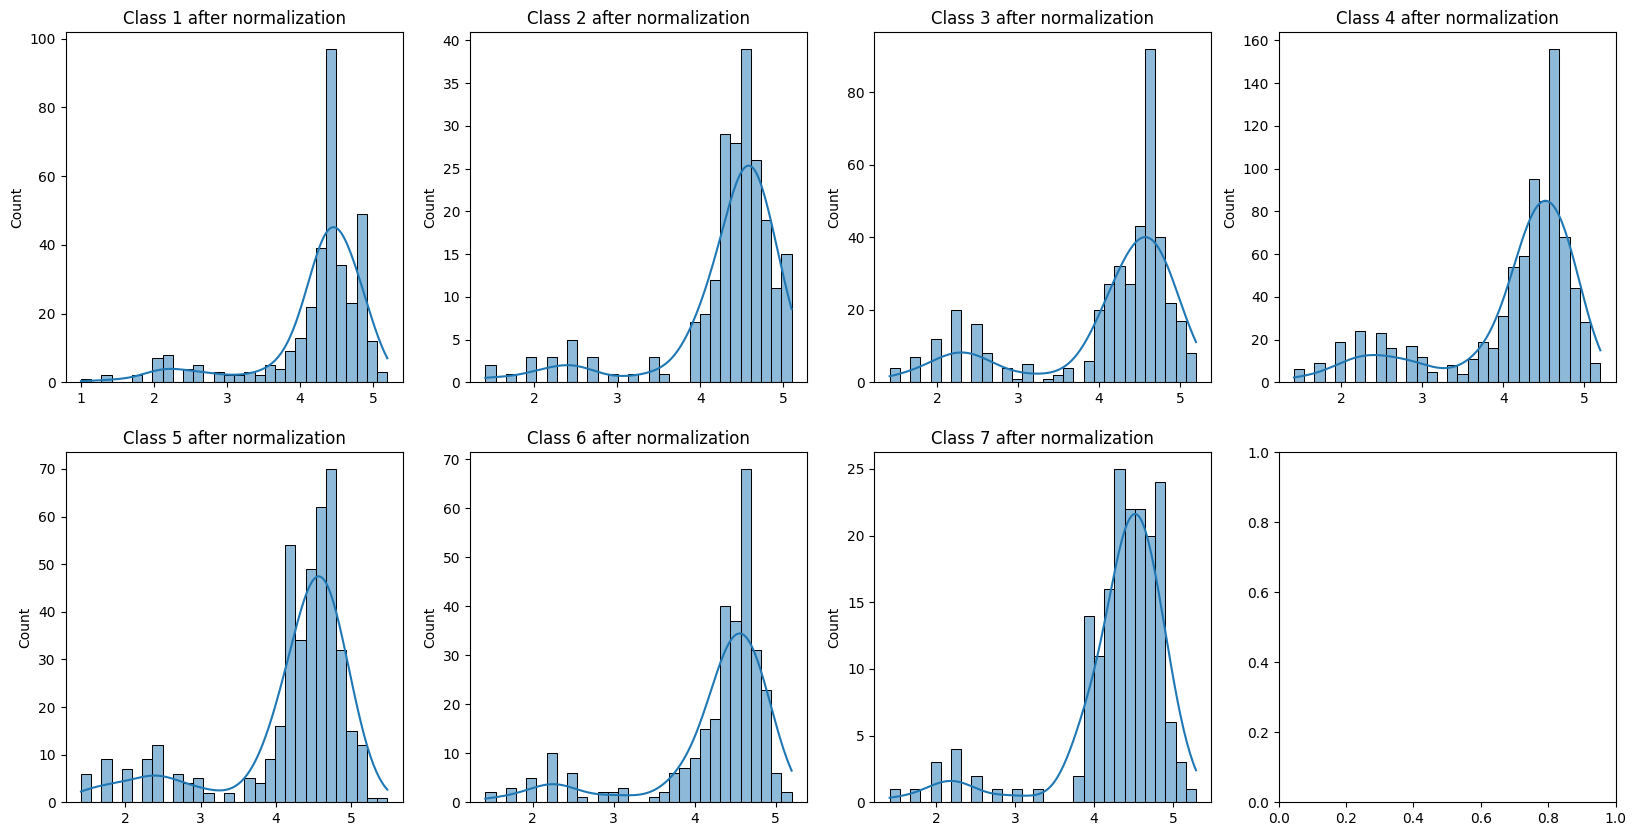

In [16]:
# subplots 2 rows 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# ravel the axs
axs = axs.ravel()
x=torch.norm(data.x, dim=1).unsqueeze(1)
# loop over the axs
for i in range(7):
    # axs[i].hist(x[data.y==i].numpy(), bins=30, label=f'class {i}', alpha=0.9)
    sns.histplot(x[data.y==i].numpy(), bins=30, label=f'class {i}', ax=axs[i], kde=True, legend=False)
    axs[i].set_title(f'Class {i+1} after normalization')


IndexError: index 20 is out of bounds for axis 0 with size 20

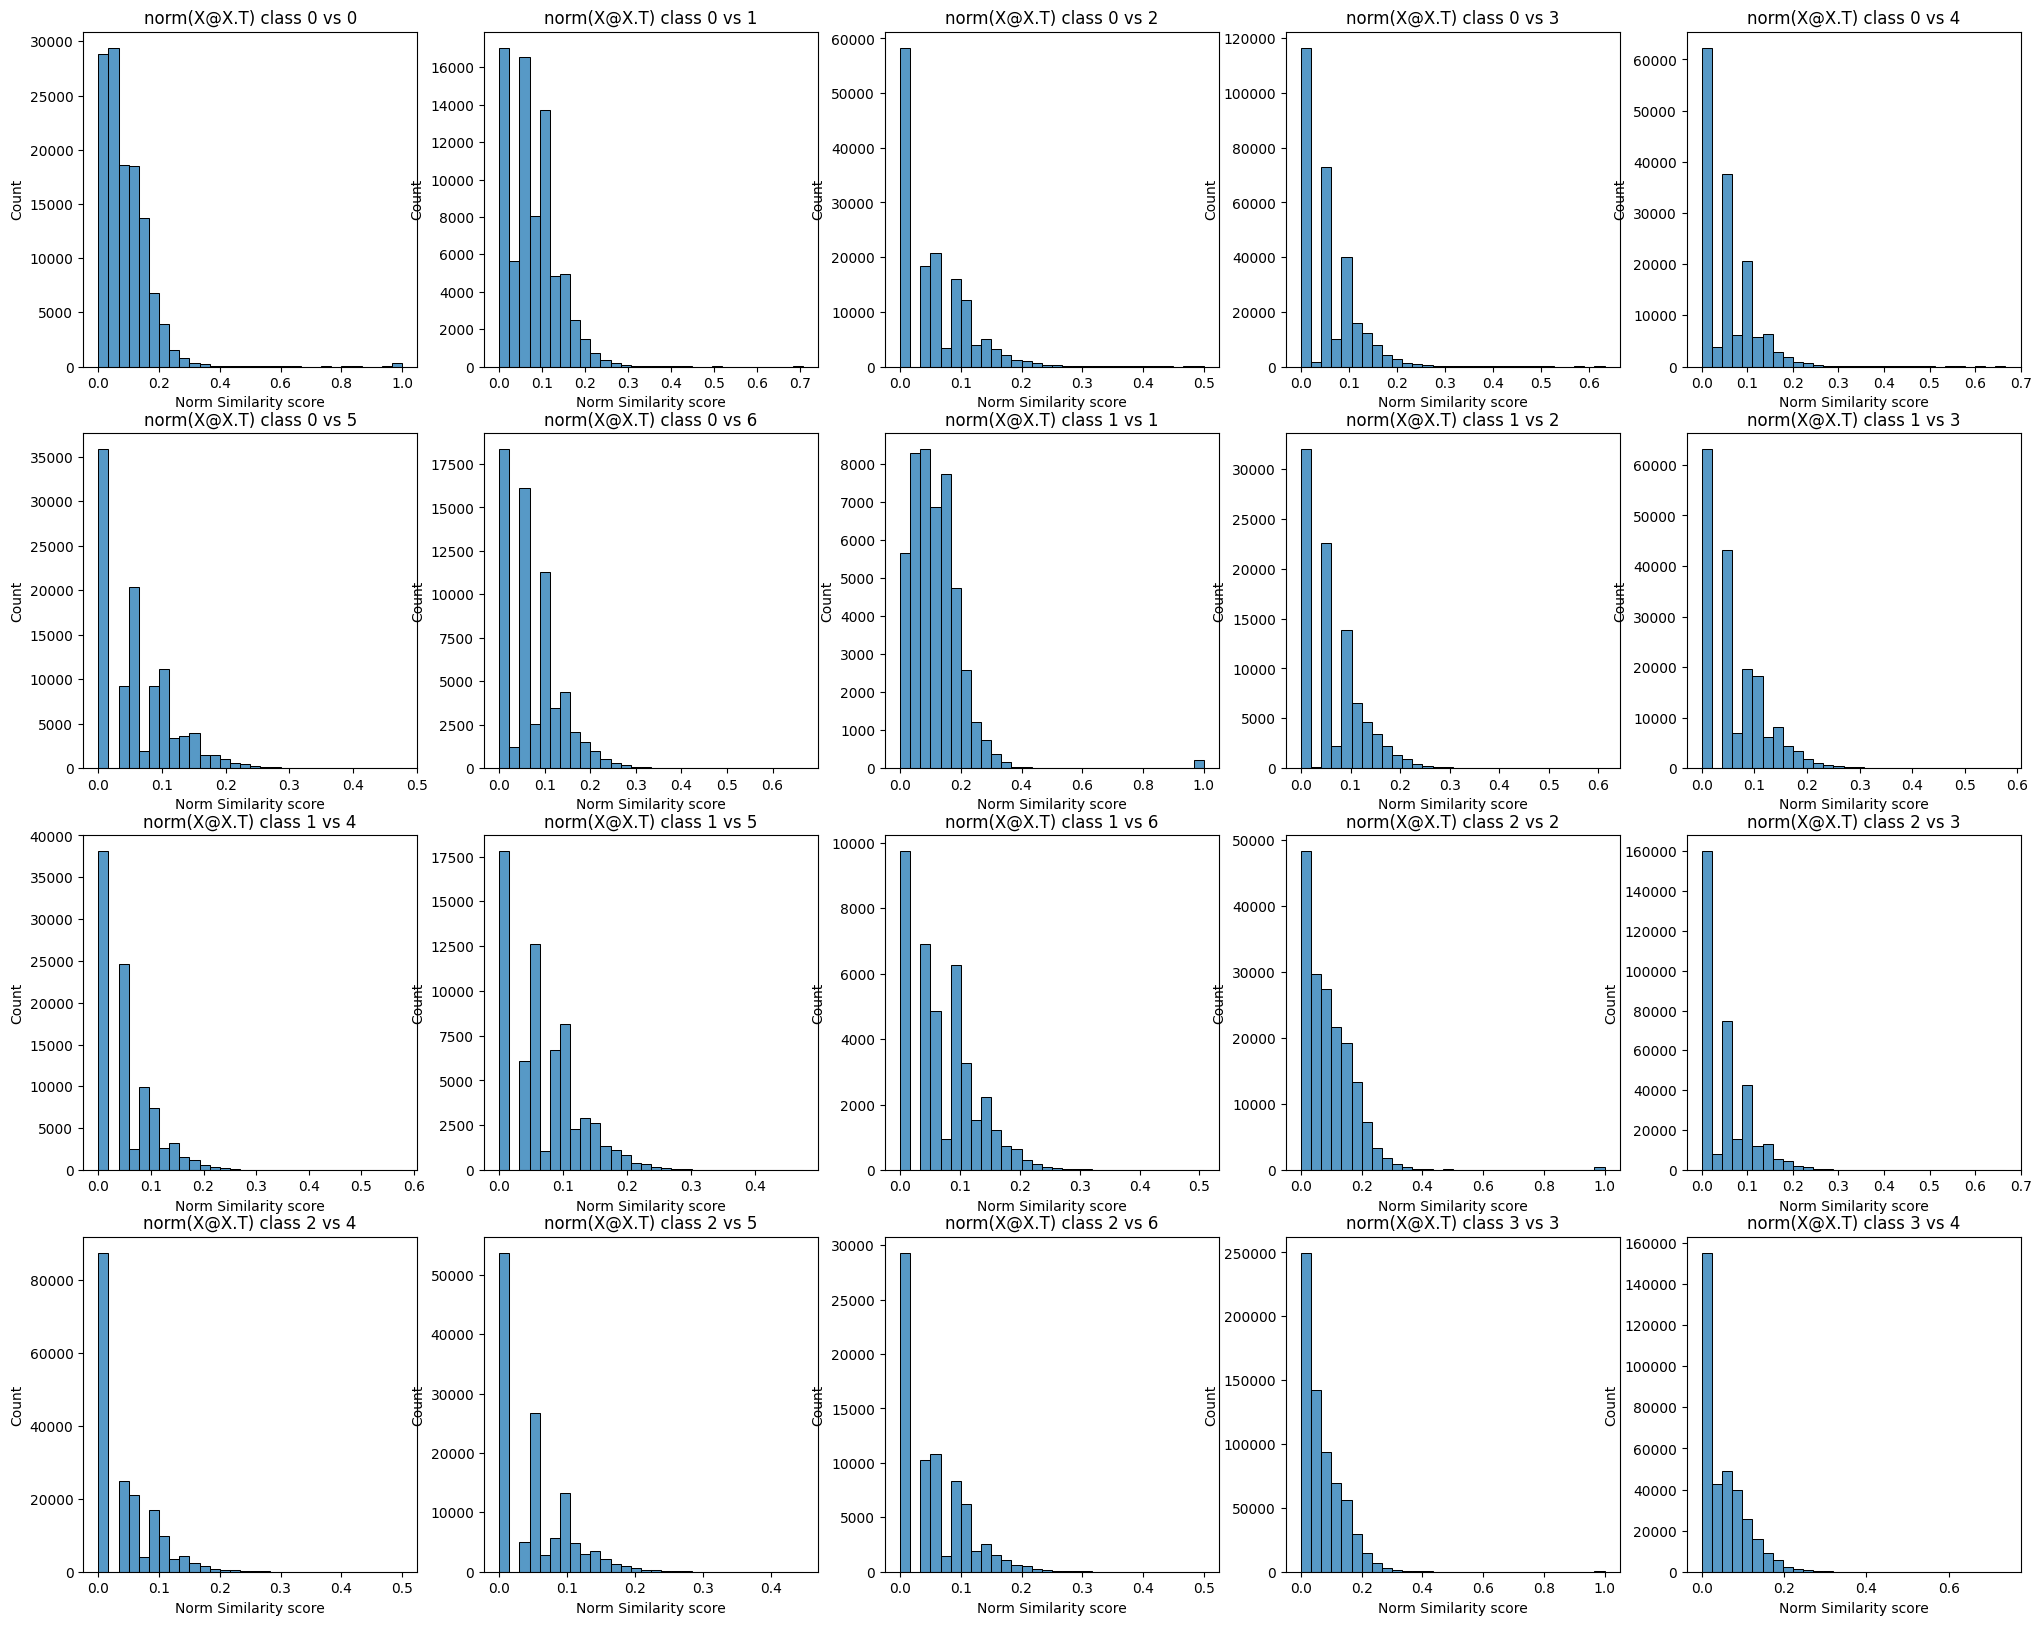

In [138]:
x = data.x.to(device)
fig, axs = plt.subplots(4, 5, figsize=(25, 20))
# ravel the axs
axs = axs.ravel()
idx=0
for i in range(7):
    for j in range(7):
        if j>=i:
            x_i = x[data.y==i]
            x_j = x[data.y==j]
            adj = (x_i@x_j.T)
            adj=adj/(x_i.norm(p=2, dim=1).unsqueeze(1)@x_j.norm(p=2, dim=1).unsqueeze(1).T)
            sns.histplot(adj.flatten().detach().cpu().numpy(), bins=30,  ax=axs[idx], kde=False, legend=False)
            # plt.yscale('log')
            axs[idx].set_xlabel('Norm Similarity score')
            axs[idx].set_title(f'norm(X@X.T) class {i} vs {j}')
            idx+=1
            if idx>24:
                break   




IndexError: index 20 is out of bounds for axis 0 with size 20

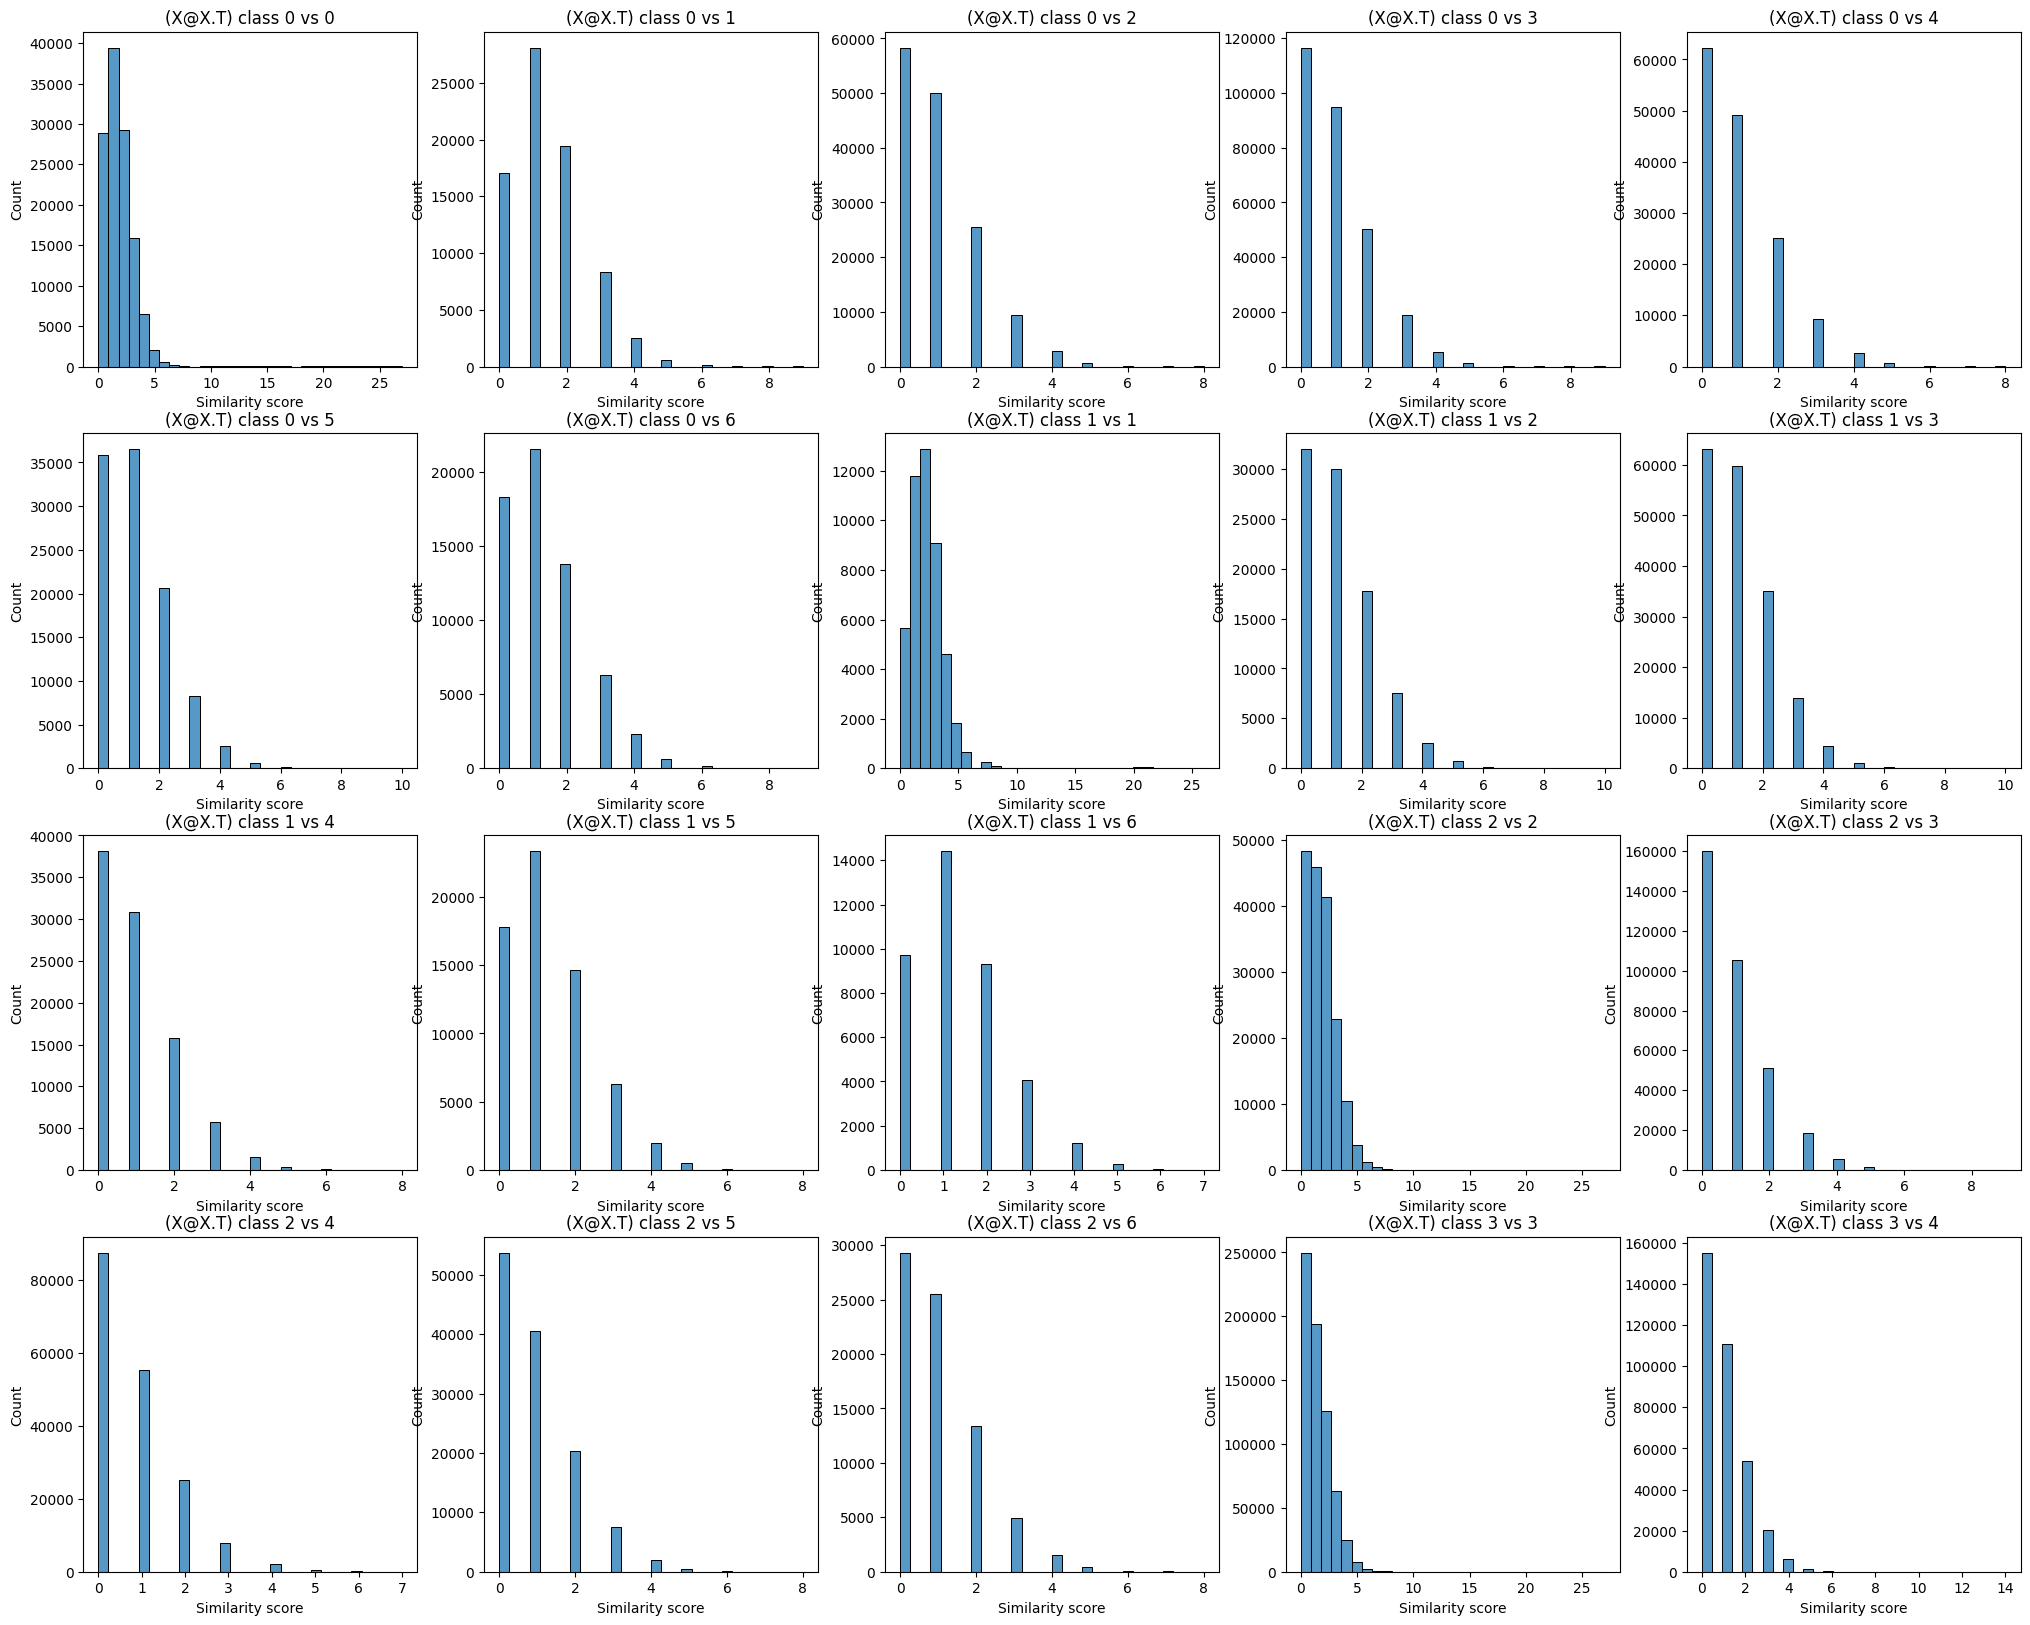

In [232]:
x = data.x.to(device)
fig, axs = plt.subplots(4, 5, figsize=(25, 20))
# ravel the axs
axs = axs.ravel()
idx=0
for i in range(7):
    for j in range(7):
        if j>=i:
            x_i = x[data.y==i]
            x_j = x[data.y==j]
            adj = (x_i@x_j.T)
            # adj=adj/(x_i.norm(p=2, dim=1).unsqueeze(1)@x_j.norm(p=2, dim=1).unsqueeze(1).T)
            sns.histplot(adj.flatten().detach().cpu().numpy(), bins=30,  ax=axs[idx], kde=False, legend=False)
            # plt.yscale('log')
            axs[idx].set_xlabel('Similarity score')
            axs[idx].set_title(f'(X@X.T) class {i} vs {j}')
            idx+=1
            if idx>24:
                break   

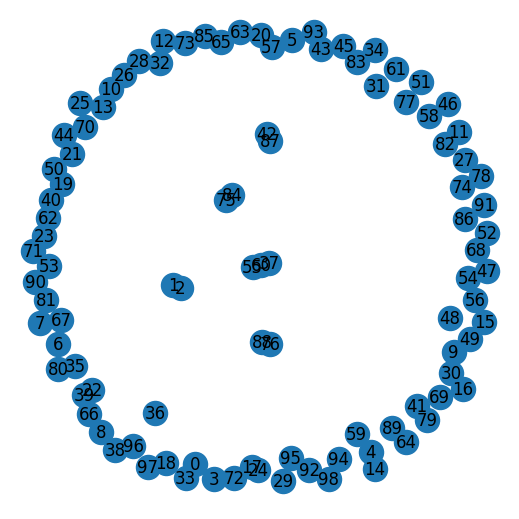

In [54]:
# pick first 100 nodes from the whole dataset and the edges between them
# most of the nodes do not have edges between them
vis_N_nodes(100, data.x, data.edge_index)

In [61]:
# find the nodes which is class 0
data_c0=data.x[data.y==0].cpu().detach().numpy()
# find the nodes which is class 1
data_c1=data.x[data.y==1].cpu().detach().numpy()
data_c2=data.x[data.y==2].cpu().detach().numpy()
data_c3=data.x[data.y==3].cpu().detach().numpy()
data_c4=data.x[data.y==4].cpu().detach().numpy()
data_c5=data.x[data.y==5].cpu().detach().numpy()
data_c6=data.x[data.y==6].cpu().detach().numpy()
data_c0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
data_overview=pd.DataFrame({
    'class 0':data_c0.mean(axis=0),
    'class 1':data_c1.mean(axis=0),
    'class 2':data_c2.mean(axis=0),
    'class 3':data_c3.mean(axis=0),
    'class 4':data_c4.mean(axis=0),
    'class 5':data_c5.mean(axis=0),
    'class 6':data_c6.mean(axis=0),
})
data_overview

,class 0,class 1,class 2,class 3,class 4,class 5,class 6
0,0.000000,0.004608,0.007177,0.003667,0.009390,0.013423,0.005556
1,0.000000,0.027650,0.011962,0.013447,0.002347,0.023490,0.016667
2,0.028490,0.046083,0.014354,0.023227,0.028169,0.033557,0.016667
3,0.042735,0.036866,0.016746,0.025672,0.028169,0.010067,0.033333
4,0.019943,0.009217,0.004785,0.008557,0.084507,0.359060,0.022222
...,...,...,...,...,...,...,...
1428,0.000000,0.004608,0.000000,0.000000,0.004695,0.000000,0.000000
1429,0.002849,0.009217,0.016746,0.012225,0.016432,0.016779,0.011111
1430,0.011396,0.000000,0.000000,0.001222,0.000000,0.003356,0.000000
1431,0.019943,0.027650,0.009569,0.018337,0.025822,0.036913,0.061111


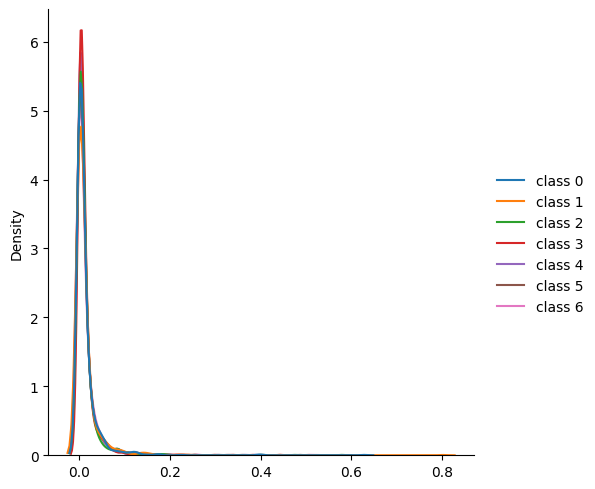

In [59]:
sns.displot(data_overview, kind='kde')

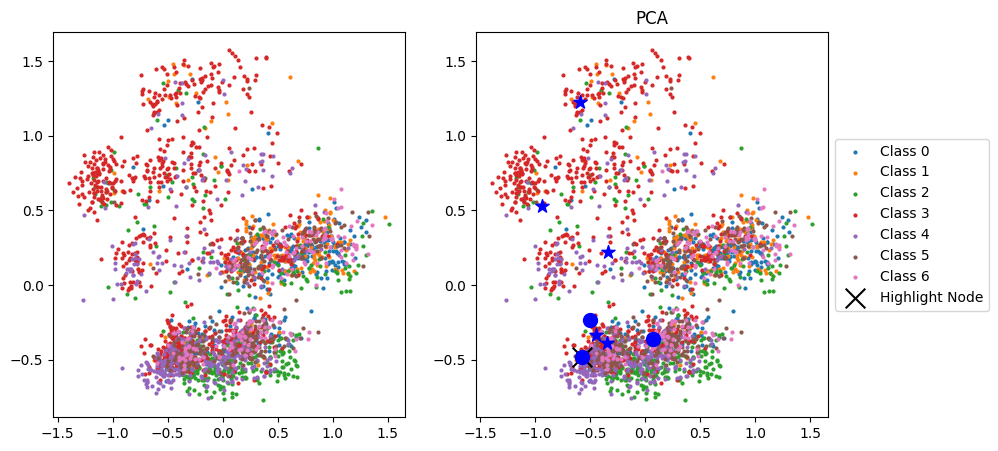

In [62]:
pca_analysis(data.x, data.y,7)
# reduce the dimensionality of the data to 2D and visualize the data
# highlight node 1728, neighbor nodes of 1728 as starts; neighbor nodes of 1728 based on similarity as dots

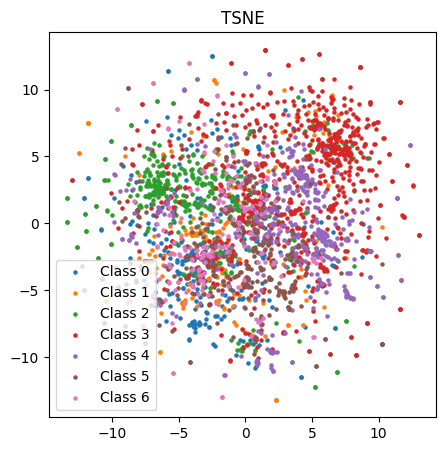

In [35]:
tsne_analysis(data.x, data.y,7) # takes a while

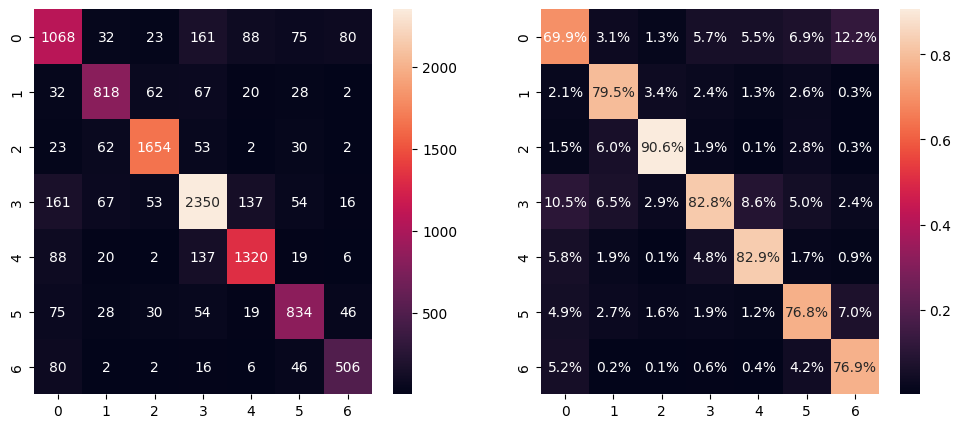

In [77]:
start_end_cluster_distribution(data.edge_index.t().tolist(), data.y,7)

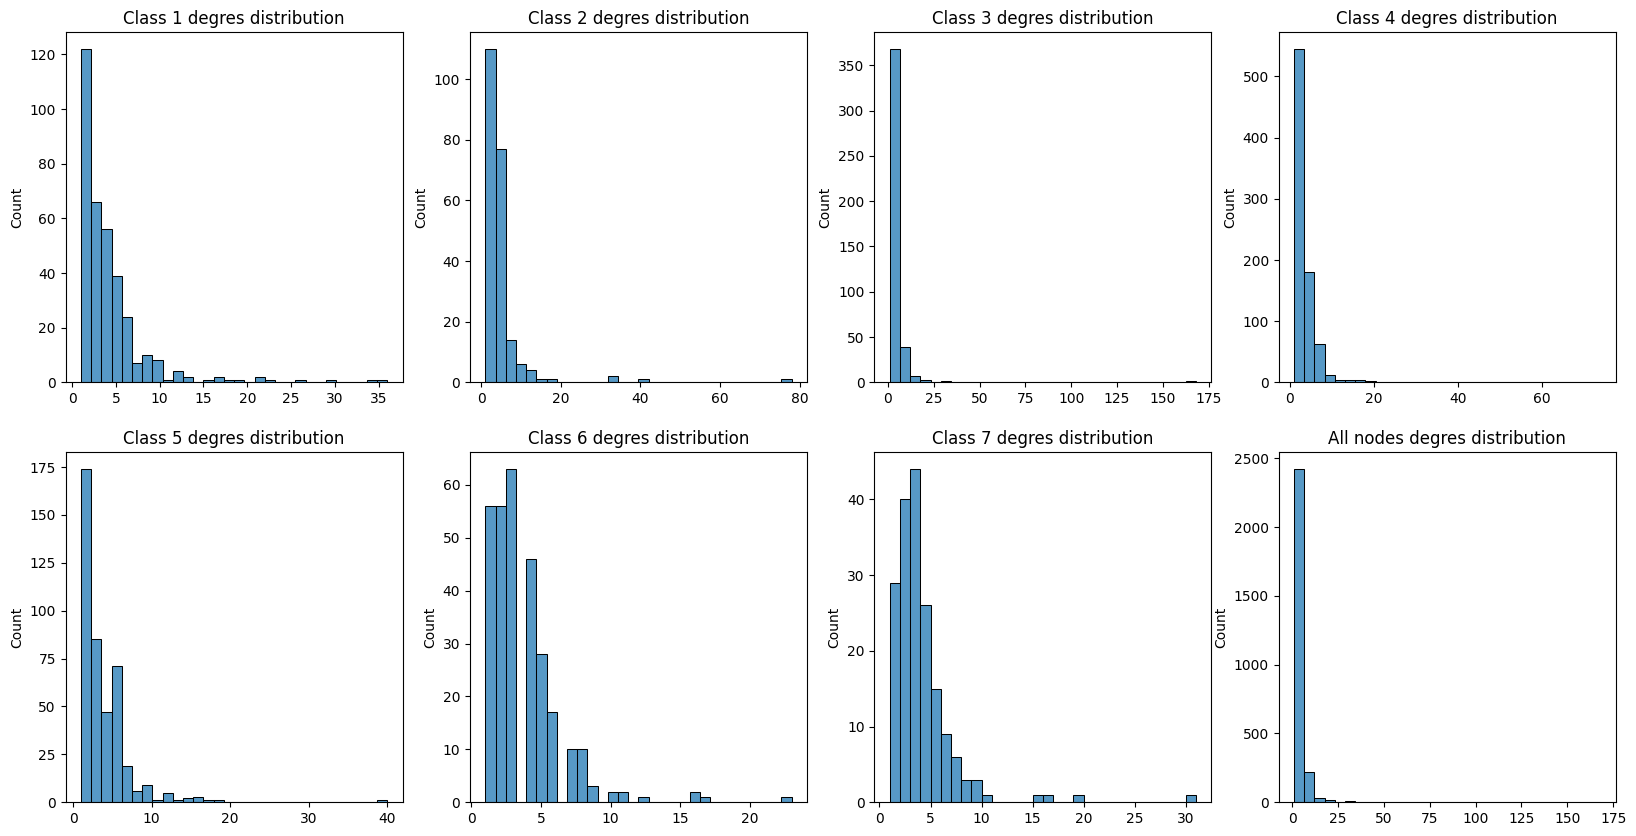

In [71]:
# degree of the nodes
degree_all_nodes=torch_geometric.utils.degree(data.edge_index[0])
# subplots 2 rows 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# ravel the axs
axs = axs.ravel()
x=torch.norm(data.x, dim=1).unsqueeze(1)
# loop over the axs
for i in range(8):
    if i<7:
        sns.histplot(degree_all_nodes[data.y==i], bins=30, label=f'class {i}', ax=axs[i], kde=False, legend=False)
        axs[i].set_title(f'Class {i+1} degres distribution')
    else:
        sns.histplot(degree_all_nodes, bins=30, label=f'all nodes', ax=axs[i], kde=False, legend=False)
        axs[i].set_title(f'All nodes degres distribution')


In [80]:
# homophily: how likely nodes with the same class are near each other in the graph
# method 'edge': edge homophily ratio, the fraction of edges in a graph which connects nodes that have the same class label.
# method 'node': node homophily ratio, normalized by neighborhood size. 
# method 'edge_insensitive': normalized by number of classes and its size.

print(torch_geometric.utils.homophily(data.edge_index, data.y, method='edge'))
print(torch_geometric.utils.homophily(data.edge_index, data.y, method='node'))
# print(torch_geometric.utils.homophily(data.edge_index, data.y, method='edge_insensitive')) # not implemented in my version


0.8099659085273743
0.825157880783081


In [86]:
# not sue how to understand it; it only uses the edge_index, not the features.
print(assortativity(data.edge_index))

-0.06587088108062744


In [162]:
# p norm for the whole graph
edge,weight=torch_geometric.utils.get_laplacian(data.edge_index, normalization='sym')
l_sys=torch_geometric.utils.to_dense_adj(edge, edge_attr=weight) # output is 1*2708*2708
l_sys=l_sys[0]
p_norm=calc_p_dirichlet(data.x, l_sys)
print(p_norm)
# permute x randomly
x_permute = data.x[torch.randperm(len(data.x))]
p_norm_permute=calc_p_dirichlet(x_permute, l_sys)
print(p_norm_permute)


tensor(0.0753)
tensor(0.0799)


In [161]:
# how to get the subgraph for class 0   
# p norm for each cluster; edges between cluster are dropped in subgraph()
all_nodes_ids=torch.arange(len(data.y))
for i in range(7):
    cluster_selected=all_nodes_ids[data.y==i]
    cluster_edges, _=torch_geometric.utils.subgraph(cluster_selected, data.edge_index)

    edge,weight=torch_geometric.utils.get_laplacian(cluster_edges, normalization='sym')
    cluster_l_sys=torch_geometric.utils.to_dense_adj(edge,edge_attr=weight, max_num_nodes=len(data.y)) # output is 1*2708*2708
    cluster_l_sys=cluster_l_sys[0]
    p_norm=calc_p_dirichlet(data.x, cluster_l_sys)
    print(f'cluster {i}',f'{p_norm.item():.4f}')

cluster 0 0.0810
cluster 1 0.0799
cluster 2 0.0808
cluster 3 0.0801
cluster 4 0.0806
cluster 5 0.0804
cluster 6 0.0812


In [159]:
  # p norm for each cluster; this method k_hop_subgraph() keeps the edges between clusters since they are 1 hop away
all_nodes_ids=torch.arange(len(data.y))
for i in range(7):
    cluster_selected=all_nodes_ids[data.y==i]
    more_nodes, cluster_edges,_, _=torch_geometric.utils.k_hop_subgraph(cluster_selected,1, data.edge_index)    
    # print(len(more_nodes))
    edge,weight=torch_geometric.utils.get_laplacian(cluster_edges, normalization='sym')
    cluster_l_sys=torch_geometric.utils.to_dense_adj(edge, edge_attr=weight, max_num_nodes=len(data.y)) # output is 1*2708*2708
    cluster_l_sys=cluster_l_sys[0]
    p_norm=calc_p_dirichlet(data.x, cluster_l_sys)
    print(f'cluster {i}',f'{p_norm.item():.4f}')


cluster 0 0.0804
cluster 1 0.0800
cluster 2 0.0806
cluster 3 0.0795
cluster 4 0.0803
cluster 5 0.0801
cluster 6 0.0810


In [139]:
# negtive sampling, results 0.0817 are larger than the p norm for the whole graph 0.0753
for _ in range(3):
    neg_edges=torch_geometric.utils.negative_sampling(data.edge_index, num_nodes=len(data.y), num_neg_samples=100)
    # calculate the p norm for the negative samples
    edge,weight=torch_geometric.utils.get_laplacian(neg_edges, normalization='sym')
    l_sys=torch_geometric.utils.to_dense_adj(edge, edge_attr=weight,max_num_nodes=len(data.y)) # output is 1*2708*2708
    l_sys=l_sys[0]
    p_norm=calc_p_dirichlet(data.x, l_sys)
    print('negative sampling ',p_norm)

negative sampling  tensor(0.0819)
negative sampling  tensor(0.0818)
negative sampling  tensor(0.0819)


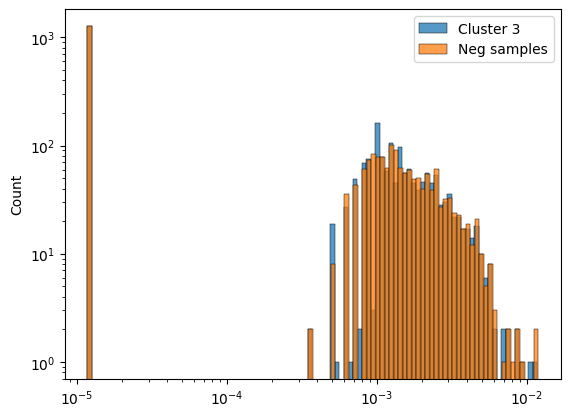

In [163]:
# for cluster 3, the highest p_norm, let's check if any features contributed to it
all_nodes_ids=torch.arange(len(data.y))
cluster_selected=all_nodes_ids[data.y==1]

more_nodes, cluster_edges,_, _=torch_geometric.utils.k_hop_subgraph(cluster_selected,1, data.edge_index)    

edge,weight=torch_geometric.utils.get_laplacian(cluster_edges, normalization='sym')
cluster_l_sys=torch_geometric.utils.to_dense_adj(edge, edge_attr=weight, max_num_nodes=len(data.y)) # output is 1*2708*2708
cluster_l_sys=cluster_l_sys[0]
p_norm_on_dims=[]
for i in range(data.x.shape[0]):
    p_norm_dim=calc_p_dirichlet(data.x[:,i:i+1], cluster_l_sys)
    p_norm_on_dims.append(p_norm_dim)
p_norm_on_dims=torch.tensor(p_norm_on_dims)

neg_edges=torch_geometric.utils.negative_sampling(data.edge_index, num_nodes=len(data.y), num_neg_samples=1000)
# calculate the p norm for the negative samples
edge,weight=torch_geometric.utils.get_laplacian(neg_edges, normalization='sym')
l_sys=torch_geometric.utils.to_dense_adj(edge, edge_attr=weight,max_num_nodes=len(data.y))[0] # output is 1*2708*2708
p_norm_on_dims_neg=[]
for i in range(data.x.shape[0]):
    p_norm_dim=calc_p_dirichlet(data.x[:,i:i+1], l_sys)
    p_norm_on_dims_neg.append(p_norm_dim)
p_norm_on_dims_neg=torch.tensor(p_norm_on_dims_neg)

sns.histplot(p_norm_on_dims, bins=100, kde=False,label='Cluster 3', legend=True,log_scale=True)
sns.histplot(p_norm_on_dims_neg, bins=100, kde=False,label='Neg samples', legend=True, log_scale=True)
plt.yscale('log')
plt.legend()


In [166]:
df=pd.DataFrame(data.x.cpu().detach().numpy())
df['y']=data.y.cpu().detach().numpy()
df

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [171]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,y
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,...,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,0.005908,0.012186,0.025849,0.026588,0.060931,0.002585,0.010709,0.002954,0.011817,0.002216,...,0.026219,0.017356,0.042097,0.010340,0.001108,0.012555,0.002216,0.024003,0.004431,2.873338
std,0.076653,0.109736,0.158715,0.160905,0.239247,0.050786,0.102948,0.054282,0.108081,0.047027,...,0.159814,0.130618,0.200849,0.101176,0.033272,0.111366,0.047027,0.153086,0.066433,1.679925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


### logistic regression

In [337]:
from sklearn.model_selection import train_test_split


X=df[df.columns[:-1]]
y=df['y']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0,stratify=y,shuffle=True)

In [338]:
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression

log = LogisticRegression(class_weight='balanced',random_state=123)    

log.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', random_state=123)

In [339]:
log.coef_.shape

(7, 1433)

In [340]:
log_train_pred_probability=log.predict_proba(X_train)
log_val_pred_probability=log.predict_proba(X_test)
test_pred=log.predict(X_test)

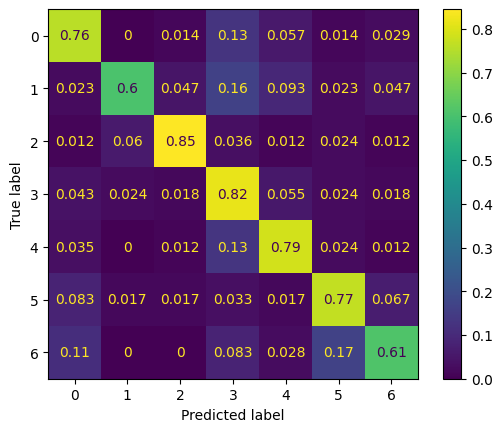

In [341]:
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred,labels=[0,1,2,3,4,5,6],normalize='true') #normalize over true/row

In [342]:
# get accuracy, precision, recall, f1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('accuracy',accuracy_score(y_test,test_pred))
print('precision',precision_score(y_test,test_pred,average='weighted'))
print('recall',recall_score(y_test,test_pred,average='weighted'))
print('f1',f1_score(y_test,test_pred,average='weighted'))

accuracy 0.7730627306273062
precision 0.7736611348913626
recall 0.7730627306273062
f1 0.7726460671058701


In [495]:
# random adj matrix of 5 by 5
adj=torch.zeros(3,3)
adj[0,1]=1
adj[1,0]=1
adj[1,2]=1
adj[2,1]=1
adj.fill_diagonal_(1)
D = torch.diag_embed(torch.sum(adj, dim=1))
deg_inv_sqrt = torch.pow(D.diag(), -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
deg_inv_sqrt = torch.diag_embed(deg_inv_sqrt)
L_sys =  deg_inv_sqrt@(D-adj)@deg_inv_sqrt
A_sys =  deg_inv_sqrt@(adj)@deg_inv_sqrt
print(adj)

tensor([[1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.]])


In [496]:
L_sys

tensor([[ 0.5000, -0.4082,  0.0000],
        [-0.4082,  0.6667, -0.4082],
        [ 0.0000, -0.4082,  0.5000]])

In [494]:
# from adj matrix to edge inddex
edge_index, weight=torch_geometric.utils.dense_to_sparse(adj)
print(edge_index)
print(torch_geometric.utils.get_laplacian(edge_index, weight, normalization='sym'))

row, col = edge_index[0], edge_index[1]
deg = scatter(weight, row, 0, dim_size=3, reduce='sum')
print(deg)

tensor([[0, 0, 1, 1, 1, 2, 2],
        [0, 1, 0, 1, 2, 1, 2]])
(tensor([[0, 1, 1, 2, 0, 1, 2],
        [1, 0, 2, 1, 0, 1, 2]]), tensor([-0.7071, -0.7071, -0.7071, -0.7071,  1.0000,  1.0000,  1.0000]))
tensor([2., 3., 2.])


In [492]:
deg_inv_sqrt = deg.pow_(-0.5)
deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
edge_weight = deg_inv_sqrt[row] * weight * deg_inv_sqrt[col]

edge_index, edge_weight = add_self_loops(  #
            edge_index, -edge_weight, fill_value=1., num_nodes=3)

In [487]:
deg_inv_sqrt[row] * weight * deg_inv_sqrt[col]

tensor([0.7071, 0.7071, 0.7071, 0.7071])

In [493]:
edge_index, edge_weight

(tensor([[0, 0, 1, 1, 1, 2, 2, 0, 1, 2],
         [0, 1, 0, 1, 2, 1, 2, 0, 1, 2]]),
 tensor([-0.5000, -0.4082, -0.4082, -0.3333, -0.4082, -0.4082, -0.5000,  1.0000,
          1.0000,  1.0000]))

In [419]:
# eigenvectors and eigenvalues of adj
eigen_values, eigen_vectors= torch.linalg.eigh(adj)
print(eigen_values)
print(eigen_vectors)

tensor([-1.,  0.,  1.])
tensor([[-0.7071,  0.0000,  0.7071],
        [ 0.7071,  0.0000,  0.7071],
        [ 0.0000,  1.0000,  0.0000]])


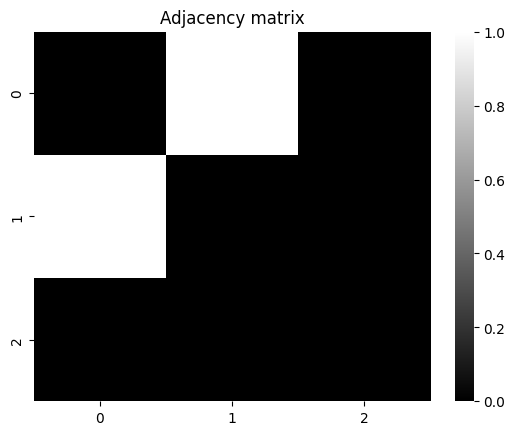

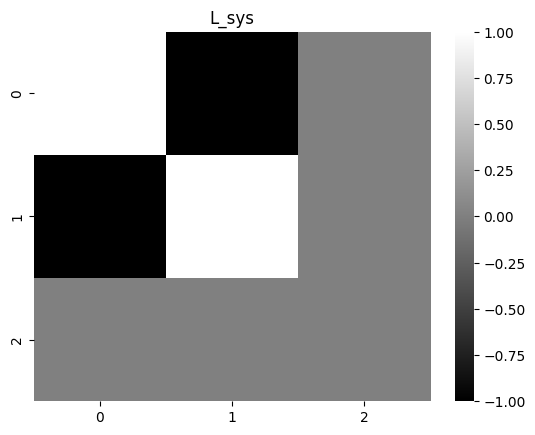

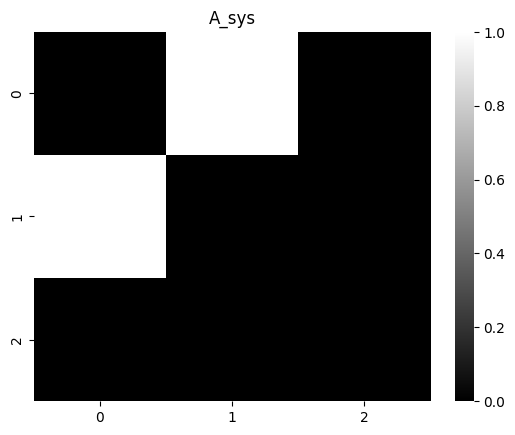

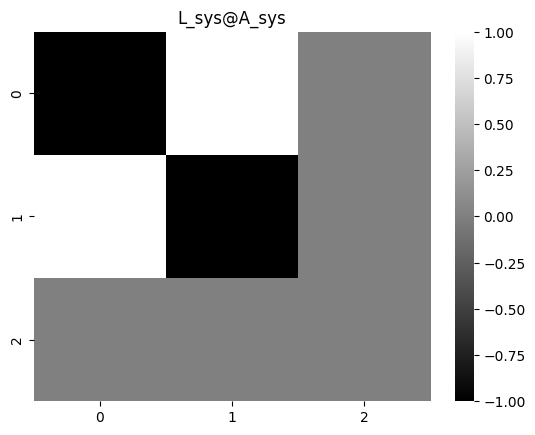

Text(0.5, 1.0, 'eigen_vectors')

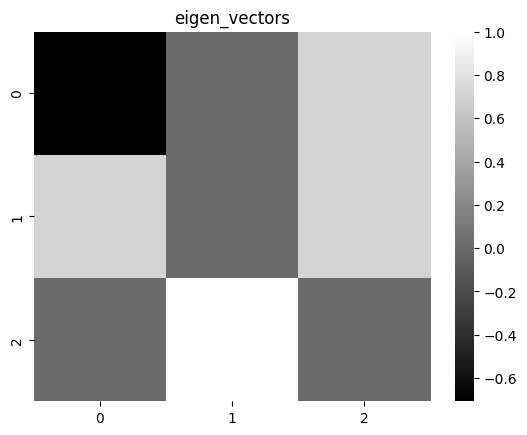

In [420]:
# show heat map of the adj matrix, use black/whtie color
sns.heatmap(adj, annot=False, fmt=".2f", cmap='gray')
plt.title('Adjacency matrix')
plt.show()
sns.heatmap(L_sys, annot=False, fmt=".2f",cmap='gray')
plt.title('L_sys')
plt.show()
sns.heatmap(A_sys, annot=False, fmt=".2f",cmap='gray')
plt.title('A_sys')
plt.show()
sns.heatmap(L_sys@A_sys, annot=False, fmt=".2f",cmap='gray')
plt.title('L_sys@A_sys')
plt.show()
sns.heatmap(eigen_vectors, annot=False, fmt=".2f",cmap='gray')
plt.title('eigen_vectors')

# Model analysis

In [279]:
from utils_analysis import *
from utils_model import *

In [320]:
hidden_dim=128
drop=0.2
th1=0
th2=1
mode=1
num_centroids=7
train_size=140
m=1
kernal_features=1024
DATA_SET='Cora'
i=0
train_loader, val_loader, test_loader, x  = load_dataset_1(train_size)

model_mode1 = GNN3(feature_dim=x.shape[1],out_dim=7, hidden_dim=hidden_dim, create_graph=True,
                                    drop=drop, th1=th1, th2=th2, mode=mode, saved_graph=None,num_centroids=num_centroids,
                                    ).to(device)
mode=0
model_mode_gcn = GNN(feature_dim=data.x.shape[1],out_dim=7, hidden_dim=hidden_dim, create_graph=None,
                                    drop=drop, th1=th1, th2=th2, mode=mode, saved_graph=None).to(device)
path=osp.join('/mnt/d1/siji/projects/semi_graph/models/',f'v3_{DATA_SET}_mode_{mode}_{train_size}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_th2_{th2}_iter_{i}.pt')
path=osp.join('/mnt/d1/siji/projects/semi_graph/models/',f'v3_{DATA_SET}_mode_{mode}_{train_size}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_centroids_{num_centroids}.pt')
path=osp.join('/mnt/d1/siji/projects/semi_graph/models/',f'v1_{DATA_SET}_mode_{mode}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_th2_{th2}_iter_{i}.pt')
                        
load_model(model_mode_gcn, path)

mode=0
th1=0
th2=1
num_centroids=3
model_mode0 = GNN3(feature_dim=x.shape[1],out_dim=7, hidden_dim=hidden_dim, create_graph=True,
                                    drop=drop, th1=th1, th2=th2, mode=mode, saved_graph=None,num_centroids=num_centroids,
                                    ).to(device)
path=osp.join('/mnt/d1/siji/projects/semi_graph/models/',f'v3_{DATA_SET}_mode_{mode}_{train_size}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_th2_{th2}_iter_{i}.pt')
path=osp.join('/mnt/d1/siji/projects/semi_graph/models/',f'v3_{DATA_SET}_mode_{mode}_{train_size}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_centroids_{num_centroids}.pt')
load_model(model_mode0, path)

train size: torch.Size([140, 1433])
test_size: torch.Size([2054, 1433])


/mnt/d1/siji/projects/semi_graph/utils_model.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float).to(device)
/mnt/d1/siji/projects/semi_graph/utils_model.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val= torch.tensor(x_val, dtype=torch.float).to(device)
/mnt/d1/siji/projects/semi_graph/utils_model.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float).to(device)
/mnt/d1/siji/projects/semi_graph/utils_model.py:55: UserWarning: To cop

GNN3(hs=128, drop=0.2)

In [253]:
def plot_cosine_similarity(data, choose_class,  model, m=0):  

    centers=model.centroids[m].detach().cpu()
    x=data.x[data.y==choose_class][-140:,model.kernal_idxs[m].detach().cpu()]
    cos_centers = (centers@centers.T)
    cos_centers.diagonal().fill_(-1)
    cos_x_centers=(centers@x.T)
    # cos_x_centers.diagonal().fill_(-1)
    cos_x_x=(x@x.T)
    cos_x_x.diagonal().fill_(-1)
    print(x.shape, centers.shape, cos_x_centers.shape)
    
    # centers=model.centroids_nn[m](model.centroids[m]).detach().cpu()
    
    # center_norms=torch.norm(centers, p=2, dim=1).unsqueeze(1)
    # cos_centers=cos_centers/(center_norms@center_norms.T)

    # x=data.x[:,model.kernal_idxs[m].detach().cpu()]
    # x=model.centroids_nn[m](x[data.y==choose_class].to(device)).detach().cpu()
    # x=model.centroids_nn[m](x.to(device)).detach().cpu()
    
    
    # x_norm=x.norm(p=2, dim=1).unsqueeze(1)
    

    # cos_x_centers=cos_x_centers/(x_norm@center_norms.T)
    # count >0.9
    # print(torch.sum(cos_x_centers>1))
    # cos_x_x=x@x.T/(x_norm@x_norm.T)
    
    
    fig,ax=plt.subplots()
    # ax.hist(cos_centers.flatten(), bins=10,label='centers', alpha=1)
    ax.hist(cos_x_x.flatten(), bins=100,label=f'x_x for class {choose_class}',alpha=0.8)
    ax.hist(cos_x_centers.flatten(), bins=100, label=f'x vs centers for class {choose_class}', alpha=0.8)


    plt.yscale('log')
    plt.legend()
    plt.show()

# plot_cosine_similarity(data, 0, model_mode0)
plot_cosine_similarity(data, 0, model_mode1, m=0)
plot_cosine_similarity(data, 1, model_mode1, m=0)
# plot_cosine_similarity(data, 2, model_mode1, m=0)
# plot_cosine_similarity(data, 3, model_mode1, m=0)
# plot_cosine_similarity(data, 4, model_mode1, m=0)
# plot_cosine_similarity(data, 5, model_mode1, m=0)
# plot_cosine_similarity(data, 6, model_mode1, m=0)


AttributeError: 'GNN4' object has no attribute 'kernal_idxs'

In [328]:
@torch.no_grad()
def test1(model, data, labels,  mask, crit):
    model.eval()
    # return acc
    _, pred, p_norm = model(data)
    pred = pred.cpu()
    p_norm = p_norm.cpu()
    mask = mask.cpu()
    labels = labels.cpu()
    loss = crit(pred[mask], labels[mask])
    
    # calculate accuracy
    acc = ((pred[mask].argmax(dim=-1) == labels[mask]
            ).sum().float() / mask.sum()).cpu()
    # save pred into pt file
    # torch.save(pred, f'./results/{DATA_SET}_pred_Infer.pt')
    
    return loss, acc, p_norm

In [329]:

print(test1(model_mode_gcn.to(device), data.to(device), data.y, data.train_mask, nn.CrossEntropyLoss()))
# print(test_iris_emb(model_mode1, test_loader, nn.CrossEntropyLoss()))

(tensor(2.1593), tensor(0.8357), tensor(0))


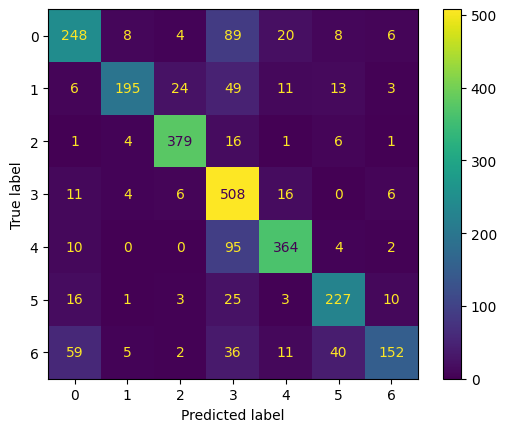

In [336]:

_,pred, p_norm = model_mode_gcn(data)

    
ConfusionMatrixDisplay.from_predictions(
    pred.argmax(dim=-1).detach().cpu().numpy().reshape(-1), data.y.detach().cpu().numpy().reshape(-1) ,labels=[0,1,2,3,4,5,6])


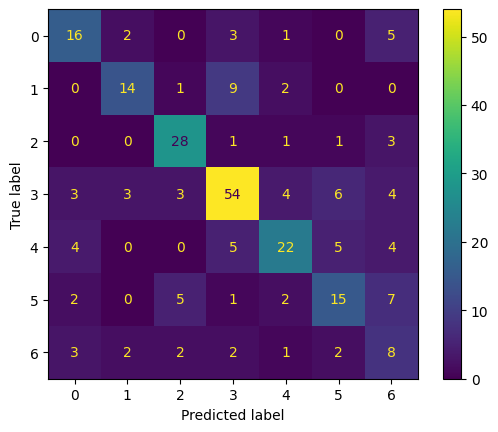

In [289]:
for test_data in test_loader:
    test_x, test_y = test_data
    pred, p_norm = model_mode1(test_x)
    break
    
ConfusionMatrixDisplay.from_predictions(
    test_y.detach().cpu().numpy().reshape(-1), pred.argmax(dim=-1).detach().cpu().numpy().reshape(-1),labels=[0,1,2,3,4,5,6])


In [87]:
# get pred result
# load tensor from fn.pt file
pred_gcn=torch.load(f'./results/{DATA_SET}_pred_GCN.pt')
pred_mlp=torch.load(f'./results/{DATA_SET}_pred_MLP.pt')
pred_infer=torch.load(f'./results/{DATA_SET}_pred_Infer.pt')

# print the true label and pred label
start_at=20
CHECH_NUM=30
gt_y=data.y[data.test_mask][start_at:CHECH_NUM]

pred_gcn=pred_gcn[data.test_mask].argmax(dim=-1)[start_at:CHECH_NUM]
pred_mlp=pred_mlp[data.test_mask].argmax(dim=-1)[start_at:CHECH_NUM]
pred_infer=pred_infer[data.test_mask].argmax(dim=-1)[start_at:CHECH_NUM]

In [88]:
print('GT:\t',gt_y)
print('GCN:\t',pred_gcn)
print('Infer:\t',pred_infer)
print('MLP:\t',pred_mlp)

# test set start at index 1708

GT:	 tensor([3, 2, 2, 2, 2, 2, 2, 1, 2, 2])
GCN:	 tensor([2, 2, 2, 2, 2, 1, 2, 1, 2, 2])
Infer:	 tensor([3, 0, 2, 2, 6, 0, 2, 5, 2, 2])
MLP:	 tensor([0, 5, 2, 0, 1, 1, 2, 5, 2, 2])


In [74]:
# find the 2nd node, GCN is correct, both MLP/Infer is wrong
data.y[1709]

tensor(3)

In [101]:
# pick a node, see the original edgelist vs inferred edgelist
node_idx=1728
# original edge list
original_edges_set = []
edges = data.edge_index.t().tolist()
for start_nodes in (edges):
    if start_nodes[0] ==node_idx and start_nodes[1] !=node_idx:
        original_edges_set.append(start_nodes[1])
     
# inferred edge list
inferred_edges_set = []
decode = data.x.to(device)
decode = (decode@decode.T)
adj = torch.sigmoid(decode)
neighbors = adj[node_idx]
for i, neighbor in enumerate(neighbors):
    if neighbor>0.98:
        inferred_edges_set.append(( i))
        
print(original_edges_set)
print(inferred_edges_set)
# find intersection of original and inferred
intersection = set(original_edges_set).intersection(set(inferred_edges_set))
print('intersetion', intersection)


[961, 1358, 2257, 2555, 2599]
[1299, 1728, 2577]
intersetion set()


In [168]:
# we want to see filter out the edge list based on cluster
# find the nodes which is class 0
keep_cluster=0
filtter_edges = []
for edge in data.edge_index.t().tolist():
    start_node, end_node = edge
    start_class = data.y[start_node]
    end_class = data.y[end_node]
    
    if start_class==keep_cluster or end_class==keep_cluster:
        filtter_edges.append(edge)
# reduce data.x based on filtered_edges
filtter_edges=torch.tensor(filtter_edges).t()
desc=scatter(data.x[filtter_edges[0]], filtter_edges[1], dim=0,  reduce='add')

In [169]:
desc.shape

torch.Size([2703, 1433])

In [177]:
a=torch.ones((3,3))
src=torch.ones((3,3))
index = torch.tensor([[0,0,1,1,2], [0,1,1,0,2]])

print(index[0].shape)
# dest.scatter_add_(1, index, src)    
desc=scatter(src[index[0]], index[1], dim=0,  reduce='add')
#  scatter(inputs, index, dim=self.node_dim, dim_size=dim_size,
                        #    reduce=self.aggr)
print(desc.shape)
print(desc)

torch.Size([5])
torch.Size([3, 3])
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [1., 1., 1.]])


In [299]:
a=torch.tensor([[1],[2.],[3]]) 

b=torch.clone(a)
# a=a.unsqueeze(1) # add dim in the middle
# b=b.unsqueeze(0) # add dim in the front

# src=a-b
# src=src.squeeze()
print('distance matrix ',src.shape)
l=torch.tensor([[1.,0,0],[0,1,0],[0,0,1]])
l_list=torch.tensor([[0,1,2],[0,1,2]])
scatter(a[l_list[0]], l_list[1], dim=0,  reduce='minus')

distance matrix  torch.Size([3])


ValueError: 

## Calcualte P_direchlet

In [377]:
# adj=torch.tensor([[1.,0,0],[0,1,0],[0,0,1]])
adj=torch.zeros((3,3))
adj[0][1]=1
adj[1][0]=1
adj[0][2]=1
adj[2][0]=1
# adj[1][2]=1
# adj[2][1]=1 
# adj[0][2]=1
# adj[2][0]=1
x=torch.tensor([[4,4],[2.,2],[2,2]]) # 3x1



# normalize adj
D = torch.diag_embed(torch.sum(adj, dim=1))
L = D - adj
deg_inv_sqrt = torch.pow(D.diag(), -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
deg_inv_sqrt = torch.diag_embed(deg_inv_sqrt)
L_sys = deg_inv_sqrt@L@deg_inv_sqrt

print(torch.sqrt(torch.sum(torch.diag(x.T@L_sys@x))) ) # should only use diagonal sum
print(x.T@L_sys@x)
print(x.T@L@x)

tensor(1.6569)
tensor([[1.3726, 1.3726],
        [1.3726, 1.3726]])
tensor([[8., 8.],
        [8., 8.]])


In [390]:
# adj=torch.tensor([[1.,0,0],[0,1,0],[0,0,1]])
adj=torch.zeros((3,3))
adj[0][1]=1
adj[1][0]=1
# adj[0][0]=1

x=torch.tensor([[4,4],[2.,2],[2,2]]) # 3x1



# normalize adj
D = torch.diag_embed(torch.sum(adj, dim=1))
L = D - adj
deg_inv_sqrt = torch.pow(D.diag(), -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
deg_inv_sqrt = torch.diag_embed(deg_inv_sqrt)
L_sys = deg_inv_sqrt@L@deg_inv_sqrt
A_sys = deg_inv_sqrt@adj@deg_inv_sqrt
print(torch.sqrt(torch.sum(torch.diag(x.T@L_sys@x))) ) 
print(torch.sqrt(torch.sum(torch.diag(x.T@A_sys@x))) ) 
print(x.T@L_sys@x)
print(x.T@L@x)

tensor(2.8284)
tensor(5.6569)
tensor([[4., 4.],
        [4., 4.]])
tensor([[4., 4.],
        [4., 4.]])


: 

In [379]:
Adj=torch.tensor([[0.,1,0],[1,0,1],[0,1,0]])
D=torch.diag_embed(torch.sum(Adj, dim=1))
L=D-Adj

print(Adj)
print(D)
print(L)

tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]])
tensor([[1., 0., 0.],
        [0., 2., 0.],
        [0., 0., 1.]])
tensor([[ 1., -1.,  0.],
        [-1.,  2., -1.],
        [ 0., -1.,  1.]])


In [381]:
deg_inv_sqrt = torch.pow(D.diag(), -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
deg_inv_sqrt = torch.diag_embed(deg_inv_sqrt)
# L_sys = deg_inv_sqrt@adj_sim@deg_inv_sqrt # CHECK !!!! 072624
L_sys = deg_inv_sqrt@(L)@deg_inv_sqrt # this is the correct way of normalize L
print(L_sys)

tensor([[ 1.0000, -0.7071,  0.0000],
        [-0.7071,  1.0000, -0.7071],
        [ 0.0000, -0.7071,  1.0000]])


In [16]:
# random
a=torch.randn(2,3)
centers=torch.randn(4,3) # have 4 centers, each center has 3 features
# find the nearest center
# distances = torch.cdist(a, centers)
# print(distances)
inner_product=torch.inner(a, centers)
print(inner_product)
# softmax
inner_product=F.softmax(inner_product, dim=1)
print(inner_product)
print(inner_product.shape)





tensor([[ 0.1832, -1.1545, -2.1010, -0.0134],
        [ 1.0045,  1.9288,  4.3862, -0.6861]])
tensor([[0.4575, 0.1201, 0.0466, 0.3758],
        [0.0302, 0.0761, 0.8882, 0.0056]])
torch.Size([2, 4])


In [42]:
centers=torch.randn(2,3) #centers
a=torch.randn(5,3) # a is a random point
# find the distance between a and centers
distances = torch.cdist(a, centers)
print(distances)
print(distances.shape)
# find the nearest center index
_, idx = distances.min(dim=1)
print(idx)

# return chosen centers
chosen_centers = centers[idx]
print(chosen_centers)

tensor([[1.5030, 2.8056],
        [1.1168, 2.5577],
        [2.8998, 1.5187],
        [2.3643, 2.6876],
        [2.1907, 0.6966]])
torch.Size([5, 2])
tensor([0, 0, 1, 0, 1])
tensor([[-1.3190,  0.0259, -0.8595],
        [-1.3190,  0.0259, -0.8595],
        [ 0.8586,  0.9361, -0.1148],
        [-1.3190,  0.0259, -0.8595],
        [ 0.8586,  0.9361, -0.1148]])


In [47]:
centers=torch.tensor([[0.,0,0],[1,1,1]]) #2,3
a=torch.tensor([[0.5,0.0,0]])
torch.cdist(a, centers, p=2)

tensor([[0.5000, 1.5000]])

In [48]:
# get iris dataset
from sklearn import datasets
iris = datasets.load_iris()
iris_data = iris.data

In [14]:
d={}
d['a']=[]

d['a'].append(1)
d['a'].append(2)
d

{'a': [1, 2]}

In [33]:
a=torch.rand(2,3)

In [35]:
a@a.T

tensor([[2.0776, 1.2194],
        [1.2194, 0.7899]])

In [52]:
a=torch.tensor([[1.,1,1]])
b=torch.tensor([[1.,2,3]])
a_b=torch.cat((a,b), dim=0)
print(a@a.T)
print(b@b.T)
print(a@b.T, b@a.T)
print(a_b.shape)


tensor([[3.]])
tensor([[14.]])
tensor([[6.]]) tensor([[6.]])
torch.Size([2, 3])


In [59]:
torch.norm(a_b, dim=1).unsqueeze(1).shape

torch.Size([2, 1])

In [60]:
norms=torch.norm(a_b, dim=1).unsqueeze(1)
(a_b@a_b.T)/(norms@norms.T)

tensor([[1.0000, 0.9258],
        [0.9258, 1.0000]])

In [48]:
# calculate the cosine similarity of a and b
print(F.cosine_similarity(a, b))
a@b.T/(torch.norm(a)*torch.norm(b))

tensor([0.9258])


tensor([[0.9258]])